<a href="https://colab.research.google.com/github/eluyutao/goemotion/blob/main/Transfer%20Learning%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install emot
!pip install tensorflow-addons

In [ ]:
import pandas as pd
import emot, re
from sklearn.model_selection import train_test_split
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
pd.set_option("display.max_columns", 99)

In [ ]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly

import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

import tensorflow as tf

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizerFast
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizerFast

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.metrics import AUC

import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from tensorflow.keras.losses import BinaryCrossentropy

dbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')

     |████████████████████████████████| 3.8 MB 5.1 MB/s 
     |████████████████████████████████| 4.3 MB 53.6 MB/s 
     |████████████████████████████████| 6.5 MB 37.4 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 895 kB 57.0 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv
goemotions_1 = pd.read_csv('goemotions_1.csv')
goemotions_2 = pd.read_csv('goemotions_2.csv')
goemotions_3 = pd.read_csv('goemotions_3.csv')
frames = [goemotions_1, goemotions_2, goemotions_3]
df = pd.concat(frames, ignore_index=True)

--2022-03-26 17:02:26--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
--2022-03-26 17:02:26--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2022-03-26 17:02:26 (125 MB/s) - ‘goemotions_1.csv’ saved [14174600/14174600]

FINISHED --2022-03-26 17:02:26--
Total wall clock time: 0.2s
Downloaded: 1 files, 14M in 0.1s (125 MB/s)
--2022-03-26 17:02:27--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostna

In [ ]:
print(df.shape)
df.head(2)

(211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.example_very_unclear.value_counts()

False    207814
True       3411
Name: example_very_unclear, dtype: int64

In [ ]:
%%time
# emotion label columns
lb_col = df.columns[9:]
print(f'Entire dataset: {df.shape}')
# remove examples that were very unclear. They do not have any emotions labels
df2 = df[~df['example_very_unclear']].copy()
print(f'{df2.shape[0]} rows left after removing records with unclear emotions')
# Sum the emotions together because there are different raters
df2 = df2[['text']+list(lb_col)].groupby(['text']).sum().reset_index()
print(f'{df2.shape[0]} rows left after deduping on text and id columns')
# keep records where there are at least two agreeing emotion labels
df2['at_least_2_agree'] = df2[lb_col].apply(lambda x: x.max(), axis=1)
df2 = df2[df2.at_least_2_agree >= 2]
print(df2.at_least_2_agree.unique())

Entire dataset: (211225, 37)
207814 rows left after removing records with unclear emotions
57730 rows left after deduping on text and id columns
[ 2  3  4  5  7  6 12 13 14  8 17  9 10 15 33 11 45 22]
CPU times: user 1.84 s, sys: 178 ms, total: 2.02 s
Wall time: 1.93 s


In [ ]:
for col in df2.columns[1:]:
    df2[col] = df2[col].apply(lambda x: 0 if x <= 1 else 1)

# df2 = df2.replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1}, inplace=False)
df_clean = df2.drop('at_least_2_agree', axis=1)
print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')

53994 rows left after removing records without having at least two raters agreeing on the emotion


In [ ]:
print(df_clean.shape)
df_clean.head(2)

(53994, 29)


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
#             print(f'{orig} -> {text}', '\n')
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(EMOTICONS_EMO[emot].split()))
#             print(f'{orig} -> {text}', '\n')
    return text

In [ ]:
%%time
print('-------replacing emoji with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emojis(x))
print('-------replacing emoticon with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emoticons(x))

-------replacing emoji with text---------
-------replacing emoticon with text---------
CPU times: user 5.17 s, sys: 0 ns, total: 5.17 s
Wall time: 5.17 s


In [ ]:
X = list(df_clean['text'])
y = df_clean.iloc[:,1:]
y.head(2)

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)
# print(f'X_train shape: {X_train.shape}')
# print(f'X_val shape: {X_val.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'Y_train shape: {Y_train.shape}')
# print(f'Y_val shape: {Y_val.shape}')
# print(f'Y_test shape: {Y_test.shape}')

### **Check the distribution of the text length. It seems like the max ~33**

Max length of words 33


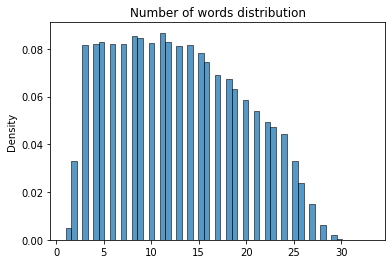

In [ ]:
import seaborn as sns

text_lens = [len(t.split()) for t in X]
text_plot = sns.histplot(data=text_lens, stat="density")
text_plot.set_title("Number of words distribution");
print("Max length of words", max(text_lens))

# **Transfer learning - DistillBERT**

## **Encoding with DistilBertTokenizerFast**

In [ ]:
# Tokenize the text
def encode_text(text):
  inputs=dbert_tokenizer(text, padding='max_length', truncation=True, return_tensors="tf", max_length=32) 
  input_ids=inputs.input_ids
  attention_mask=inputs.attention_mask
  return input_ids, attention_mask

train_input, train_mask = encode_text(X_train)
val_input, val_mask = encode_text(X_val)
test_input, test_mask = encode_text(X_test)



In [ ]:
# create a BERT tensor for the model
def bert_inputs(input_ids, attention_mask, y):

  bert_tensor1 = {'input_ids': input_ids, 'attention_mask': attention_mask}
  bert_tensor2 = tf.data.Dataset.from_tensor_slices((dict(bert_tensor1), y))

  return bert_tensor2

train_model_inputs_and_masks = bert_inputs(train_input, train_mask, y_train)
val_model_inputs_and_masks = bert_inputs(val_input, val_mask, y_val)
test_model_inputs_and_masks = bert_inputs(test_input, test_mask, y_test)

In [ ]:
def build_model(base_model, trainable=True, params={}):
    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)
    inputs = Input(shape=(max_seq_len,), dtype='int32', name='input_ids')
    masks  = Input(shape=(max_seq_len,), dtype='int32', name='attention_mask')

    # Bert Layers
    base_model.trainable = trainable
    bert = base_model.layers[0]
    dbert_output = bert(inputs, attention_mask=masks)
    dbert_last_hidden_state = dbert_output.last_hidden_state
    my_output = dbert_last_hidden_state[:, 0, :]

    # Neutral Network Layers
    X = keras.layers.BatchNormalization()(my_output)
    X = keras.layers.Dropout(0.1, name='dropout')(X)
    probs = Dense(units=y_train.shape[1], kernel_initializer=initial_weights, activation="sigmoid",  name='output')(X)

    # Construct final model
    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# dbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', output_hidden_states=False)
params= {
        "max_seq_len":32,
        "layer_dropout":0.1,
        "learning":4e-4,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
def build_model(base_model, trainable=False, params={}):
    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)
    inputs = Input(shape=(max_seq_len,), dtype='int32', name='input_ids')
    masks  = Input(shape=(max_seq_len,), dtype='int32', name='attention_mask')
    inputs_2 = {'input_ids': inputs, 'attention_mask': masks}

    # Bert Layers
    base_model.trainable = trainable
    bert = base_model.layers[0]
    dbert_output = bert(inputs_2)
    dbert_last_hidden_state = dbert_output.last_hidden_state
    my_output = dbert_last_hidden_state[:, 0, :]

    # Neutral Network Layers
    X = keras.layers.BatchNormalization()(my_output)
    X = tf.keras.layers.Dense(192, activation='relu')(X)
    X = keras.layers.Dropout(0.1, name='dropout')(X)
    probs = Dense(units=y_train.shape[1], kernel_initializer=initial_weights, activation="sigmoid",  name='output')(X)

    # Construct final model
    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    return model

# Kevin and Brandon's model difference. It seems like TFDistilBertForSequenceClassification has a slight edge
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# dbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', output_hidden_states=False)
params= {
        "max_seq_len":32,
        "layer_dropout":0.1,
        "learning":4e-4,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['attention_mask[0][0]',         
 yer)                           ast_hidden_state=(N               'input_ids[0][0]']              
                                one, 32, 768),                                                    
                                 hidden_states=None                                        

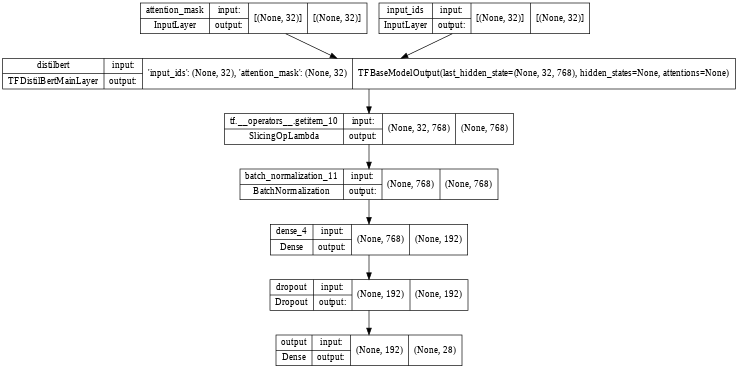

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Brandon's metrics
def compile_model(model):
    metrics = [tfa.metrics.HammingLoss(mode='multiclass', name='hamming-mc', dtype=tf.float32, threshold=0.2),
               tfa.metrics.HammingLoss(mode='multilabel', name='hamming-ml', dtype=tf.float32, threshold=0.4),
               keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32, label_smoothing=0.5),
              #  tfa.metrics.F1Score(num_classes=28, threshold=0.5),
              #  'precision', 'recall','accuracy',
               ]
    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), loss=BinaryCrossentropy(), metrics=metrics)
    return model

model = compile_model(model)

In [ ]:
# Kevin's metrics (not sure if the F1, precision and recall metrics are the one same with the paper - https://arxiv.org/pdf/2005.00547.pdf)
def compile_model(model):
    metrics = [tfa.metrics.F1Score(num_classes=28, threshold=0.5),
               tf.keras.metrics.Precision(), 
               tf.keras.metrics.Recall(),
              AUC(name="average_precision", curve="PR", multi_label=True),'accuracy']
    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), loss=BinaryCrossentropy(), metrics=metrics)
    return model

model = compile_model(model)

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,batch_size, num_epochs):

    history = model.fit(model_inputs_and_masks_train.batch(batch_size), epochs=num_epochs, validation_data=model_inputs_and_masks_val.batch(batch_size))

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, batch_size=16, num_epochs=1)

2700/2700 [==============================] - 89s 31ms/step - loss: 0.1119 - hamming-mc: 0.3748 - hamming-ml: 0.0386 - Cat-CE: 2.4368 - Bin-CE: 1.3721 - val_loss: 0.1033 - val_hamming-mc: 0.3164 - val_hamming-ml: 0.0364 - val_Cat-CE: 2.2587 - val_Bin-CE: 1.4131


In [ ]:
def eval_model(model, X_test):

    test_scores = model.evaluate(X_test.batch(16))
    return test_scores

test_scores = eval_model(model, test_model_inputs_and_masks)

338/338 [==============================] - 9s 28ms/step - loss: 0.1081 - f1_score: 0.1863 - precision_7: 0.6621 - recall_7: 0.2733 - average_precision: 0.2829 - accuracy: 0.4526
